# Метод K-Nearest Neighbors (K ближайших соседей)

Начнем разбор алгоритмов машинного обучения с наиболее прозрачной для понимания задачи классификации. Чтобы понять, что это за задача и для чего она вообще решается, давайте вспомним о весьма перспективной разработке - беспилотных автомобилях. Понятно, что сама по себе машина не понимает, что такое проезжая часть, и не может отличить человека от светофора - для этого ее надо научить различать знаки, людей, животных и т.д. Здесь, помимо достаточно сложных отраслей машинного обучения, таких как машинное зрение и системы принятия решений, используется классификация: автомобиль "учится" различать препятствия, которые необходимо объехать; людей, чтобы пропустить их при переходе дороги; знаки, чтобы точно следовать правилам. Говоря простым языком, система относит объекты к тому или иному классу, чтобы правильно себя вести при встрече с ними, то есть классификация в машинном обучении - не что иное, как задача отнесения объекта к одному из заранее определенных классов на основании его признаков.

Начнем с kNN - одного из наиболее распространенных методов классификации в ML. Его достаточно просто реализовать в отличие от других алгоритмов, поэтому для наглядности того, как в целом работает классификация, мы сначала напишем собственную реализацию и посмотрим на результаты, применив метод к стандартному датасету Iris, а затем сравним с библиотечной реализацией из библиотеки *sklearn*. Следующие алгоритмы мы не будем разбирать настолько досконально из-за трудоемкой реализации - рассмотрим общую методологию и разберем, на основе чего алгоритм принял решение в пользу того или иного класса.

Метод kNN относится к разряду ленивых классификаторов. В целом это указывает на то, что метод "обучается" лишь  на новых данных, не учитывая предыдущий опыт. В данном же случае это означает, что в процессе обучения алгоритм не делает ничего, а только сохраняет размеченные тренировочные данные. Сам процесс классификации начинается только тогда, когда появляются новые немаркированные данные - алгоритм по каким-то признакам считает расстояния между уже размеченными и еще неизвестными объектами в пространстве. Очевидно, что, если мы будем рассчитывать расстояния между известными данными и каждым новым набором неразмеченных данных, то каждый раз будем получать различные расстояния между объектами, поэтому изначально "обучать" алгоритм на одних расстояниях, чтобы он запомнил, на какой позиции к какому классу относится объект, совершенно не имеет смысла - позиций может быть бесконечное множество, поэтому хранить их все в памяти не получится.

Еще один важный момент: как понять, насколько точно модель строит прогнозы? В данном случае одним из простейших способов определить ошибку является просто вычисление отношения числа верных предсказаний к общему количеству сделанных предсказаний. Эту метрику называют *долей правильных ответов*. Очевидно, ее значения будут находиться в пределах от 0 до 1, где 0 - совершенно бесполезная модель, а 1 - абсолютно точная.

Алгоритм kNN состоит из трех последовательных этапов:
- вычислить расстояние от целевого объекта (который необходимо классифицировать) до каждого из объектов обучающей выборки (уже маркированных каким-либо классом);

<img src="https://248006.selcdn.ru/public/DS_Block2_M5_final/knn-1.png" width="50%">

- отобрать $k$ объектов обучающей выборки, расстояния до которых минимальны (на первом этапе $k$ выбирается произвольно, затем итеративно подбирается лучшее значение $k$ на основе точности полученных прогнозов при каждом из выбранных $k$);

<img src="https://248006.selcdn.ru/public/DS_Block2_M5_final/knn-2.png" width="50%">

- получить класс объекта на основе наиболее часто встречающегося среди $k$ ближайших соседей (это может быть число или название класса в зависимости от того, как изначально были обозначены классы - например, в примере с беспилотниками это может быть "человек" или "бетонный блок").

<img src="https://248006.selcdn.ru/public/DS_Block2_M5_final/knn-3.png" width="50%">

Здесь стоит отметить, что количество классов модель выясняет сама уже в процессе классификации: информация о классе содержится в самих объектах размеченных данных (во всех соседях), поэтому просто посчитать количество экземпляров одного и того же класса для алгоритма не составляет труда.

Импорт набора данных Iris.
Он представляет собой собрание морфологических измерений нескольких сортов ирисов и для каждого растения имеет 4 характеристики:
- длина чашелистика
- ширина чашелистика
- длина лепестка
- ширина лепестка

In [1]:
from sklearn.datasets import load_iris
iris_dataset = load_iris() # возвращает объект с несколькими полями

Посмотрим, что включает в себя набор данных.

In [2]:
iris_dataset.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [5]:
print(iris_dataset['DESCR']) # описание датасета

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [6]:
iris_dataset['target_names'] # виды ирисов

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [7]:
iris_dataset['feature_names'] # характеристики каждого цветка

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [8]:
print(iris_dataset['target'].shape) # каждый цветок соответствует виду
iris_dataset['target'] # 0 - setosa, 1 - versicolor, 2 - virginica

(150,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [9]:
print(type(iris_dataset['data']))
iris_dataset['data'].shape # всего 150 цветков, у каждого 4 измерения

<class 'numpy.ndarray'>


(150, 4)

Теперь взглянем на наши данные.

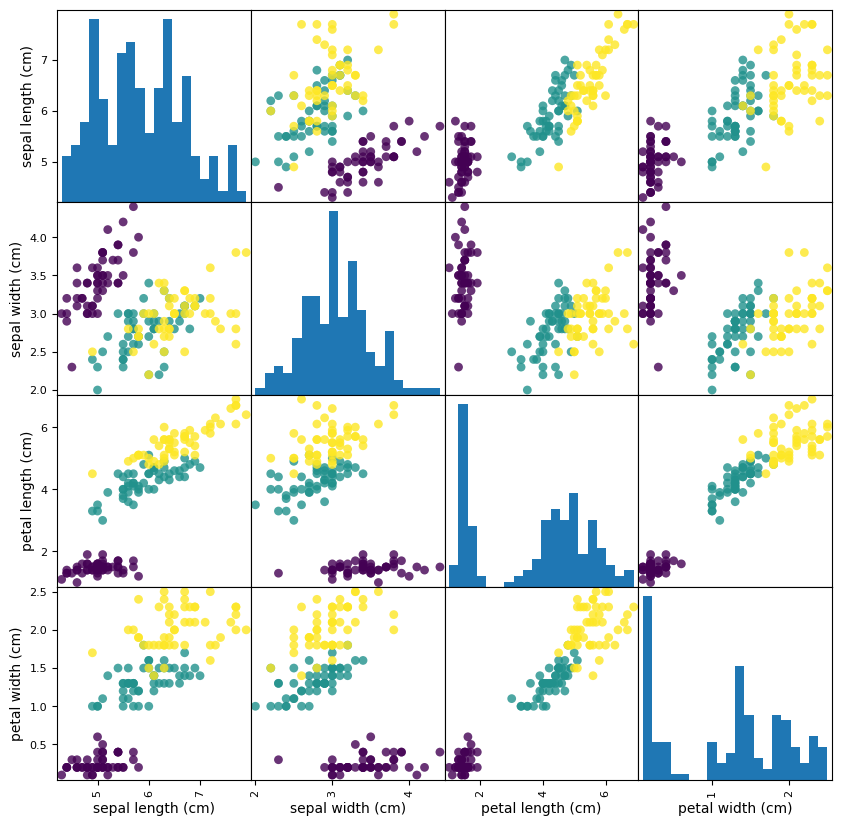

In [10]:
import pandas as pd

iris_dataframe = pd.DataFrame(iris_dataset['data'], columns=iris_dataset.feature_names)
scat_mtrx = pd.plotting.scatter_matrix(iris_dataframe, c=iris_dataset['target'], figsize=(10, 10), marker='o',
                                       hist_kwds={'bins': 20}, s=40, alpha=.8)

Из графиков мы можем заметить, что данные классов, по-видимому, хорошо сепарируются (от __separate__ - разделять) по измерениям лепестков и чашелистиков, поэтому, скорее всего, модель машинного обучения сможет научиться неплохо их разделять.

Но при четырех параметрах достаточно сложно представить, как расположены объекты относительно друг друга, так как придется работать в четырехмерном пространстве. По графикам видно, что лучше всего цветки разбиваются по измерениям длины и ширины лепестка (petal length, petal width), поэтому для наглядности оставим только эти данные.

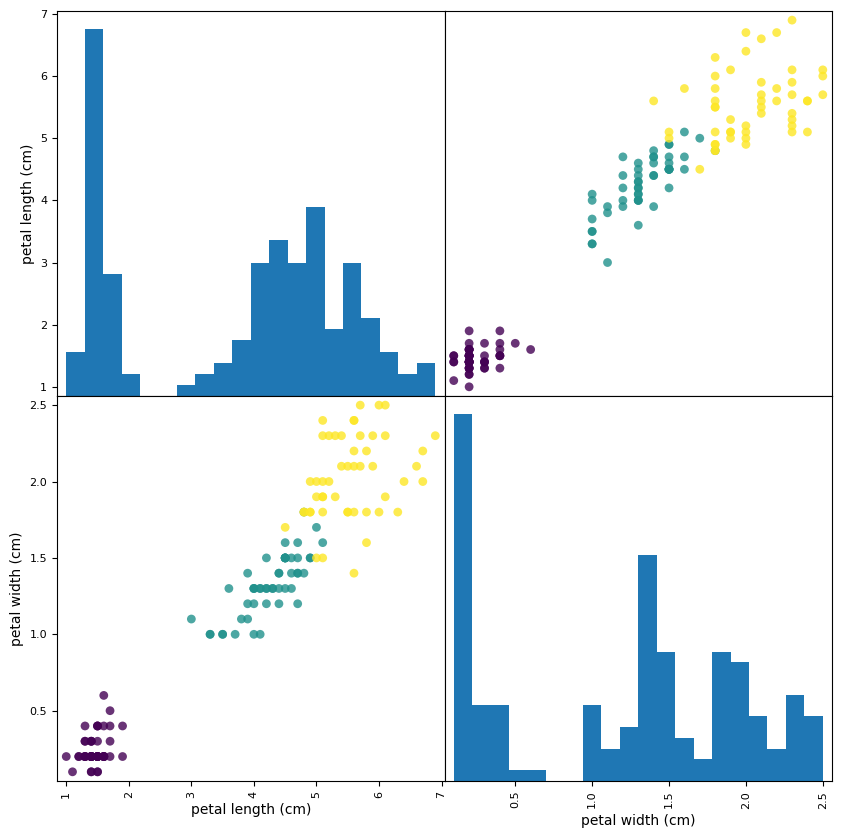

In [11]:
iris_dataframe_simple = pd.DataFrame(iris_dataset.data[:, 2:4], columns=iris_dataset.feature_names[2:4])
scat_mtrx = pd.plotting.scatter_matrix(iris_dataframe_simple, c=iris_dataset['target'], figsize=(10, 10), marker='o',
                                       hist_kwds={'bins': 20}, s=40, alpha=.8)

Разобьем данные на тренировочный и тестовый датасеты и для простоты реализации алгоритма объединим массивы признаков объектов и метки их классов, чтобы было понятно, к какому классу относится каждый объект.

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(iris_dataset.data[:, 2:4],
                                                    iris_dataset['target'],
                                                    random_state=0) # random_state - для воспроизводимости

print(f'X_train shape: {x_train.shape}, y_train shape: {y_train.shape},\n'
      f'X_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (112, 2), y_train shape: (112,),
X_test shape: (38, 2), y_test shape: (38,)


In [13]:
import numpy as np

x_train_concat = np.concatenate((x_train, y_train.reshape(112, 1)), axis=1)
x_test_concat = np.concatenate((x_test, y_test.reshape(38, 1)), axis=1)
print(f'X_train shape: {x_train_concat.shape},\n'
      f'X_test shape: {x_test_concat.shape}')

X_train shape: (112, 3),
X_test shape: (38, 3)


In [ ]:
pd.DataFrame(x_train_concat).head(5)

,0,1,2
0,4.2,1.5,1.0
1,4.0,1.2,1.0
2,5.5,2.1,2.0
3,1.3,0.2,0.0
4,5.1,2.3,2.0


Как мы видим, теперь в последнем столбце у нас присутствуют метки класса.

Приступим к реализации алгоритма.

Для начала определим метрику, по которой будем определять расстояние между объектами. Обозначим через $x = (x_1, x_2, \ldots, x_n)$ координаты объекта $x$ в n-мерном пространстве, а через $y = (y_1, y_2, \ldots, y_n)$ - координаты объекта $y$.

По умолчанию алгоритм использует метрику Минковского, которая в случае степени p = 2 обращается во всем известную из школьной геометрии Евклидову метрику - расстояние между двумя точками в пространстве:
$$
dist = \sqrt{(x_1-y_1)^2 + (x_2 - y_2)^2 + \ldots + (x_n - y_n)^2}
$$
Ее и будем использовать.

In [14]:
import math

def euclidean_distance(data1, data2):
    distance = 0
    for i in range (len(data1) - 1):
        distance += (data1[i] - data2[i]) ** 2
    return math.sqrt(distance)

Вычислим расстояния до всех точек обучающей выборки и отберем $k$ соседей (то есть тех, расстояния до которых минимальны).

In [15]:
def get_neighbors(train, test, k=1):
    distances = [(train[i][-1], euclidean_distance(train[i], test))
                  for i in range (len(train))]
    distances.sort(key=lambda elem: elem[1])

    neighbors = [distances[i][0] for i in range (k)]
    return neighbors

Теперь получим прогноз на основе классов соседей. Посчитаем, сколько объектов каждого класса присутствует среди $k$ ближайших к целевому, и затем причислим его к тому классу, экземпляров которого больше всего.

In [16]:
def prediction(neighbors):
    count = {}
    for instance in neighbors:
        if instance in count:
            count[instance] +=1
        else :
            count[instance] = 1
    target = max(count.items(), key=lambda x: x[1])[0]
    return target

Напишем последнюю функцию для оценки точности прогнозов. О ней речь шла в самом начале - это просто отношение верных прогнозов к общему количеству прогнозов.

In [17]:
def accuracy(test, test_prediction):
    correct = 0
    for i in range (len(test)):
        if test[i][-1] == test_prediction[i]:
            correct += 1
    return (correct / len(test))

Посмотрим, как работает наш алгоритм.

In [18]:
predictions = []
for x in range (len(x_test_concat)):
    neighbors = get_neighbors(x_train_concat, x_test_concat[x], k=5)
    result = prediction(neighbors)
    predictions.append(result)
#     print(f'predicted = {result}, actual = {x_test_concat[x][-1]}') # если есть интерес посмотреть, какие конкретно прогнозы некорректны
accuracy = accuracy(x_test_concat, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9736842105263158


Теперь импортируем библиотечную версию алгоритма.

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

Объект *knn* инкапсулирует алгоритм, который будет использоваться для построения модели из обучающих данных, а также для прогнозирования новых точек данных. Он также будет содержать информацию, которую алгоритм извлек из обучающих данных. В случае *KNeighborsClassifier* он будет просто хранить учебный набор.

Для построения модели на обучающем множестве вызывается метод *fit* объекта *knn*, который принимает в качестве аргументов массив NumPy *x_train*, содержащий обучающие данные, и массив NumPy *y_train* соответствующих обучающих меток.

In [20]:
knn_model = knn.fit(x_train, y_train)

Для предсказаний вызывается метод *predict*, который в качестве аргументов принимает тестовые данные.

In [21]:
knn_predictions = knn.predict(x_test)
knn_predictions

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2])

Для проверки импортируем простую встроенную метрику *accuracy_score*, которая определяет долю правильных ответов.

In [22]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, knn_predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9736842105263158


Как мы видим, реализованный вручную алгоритм при данных параметрах по точности сопоставим с библиотечной моделью, однако на практике стоит пользоваться именно готовыми реализациями, так как зачастую они гораздо лучше оптимизированы и быстрее/лучше работают с большими выборками данных.

В целом, несмотря на то, что алгоритм достаточно прост для понимания и реализации, он нашел широкое применение в таких областях как рекомендательные системы, семантический поиск и обнаружение аномалий. Однако для его применения мы должны быть в состоянии сохранить весь обучающий набор в памяти, а выполнение классификаций может быть вычислительно дорогостоящим, поскольку алгоритм анализирует все точки данных для каждой классификации. По этим причинам kNN лучше всего применять к небольшим наборам данных, которые не имеют огромного набора признаков.